In [1]:
import pandas as pd
from siuba import _, mutate, count, filter, group_by, ungroup, head
from siuba import add_count
from siuba.dply.forcats import fct_reorder, fct_lump
from siuba.experimental.datetime import floor_date
from plotnine import *

gdpr_violations = pd.read_csv(
        'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-04-21/gdpr_violations.tsv',
        sep = "\t", parse_dates = ["date"]
    )

gdpr_text = pd.read_csv(
    'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-04-21/gdpr_text.tsv',
    sep = "\t"
)

## Countries with most fines

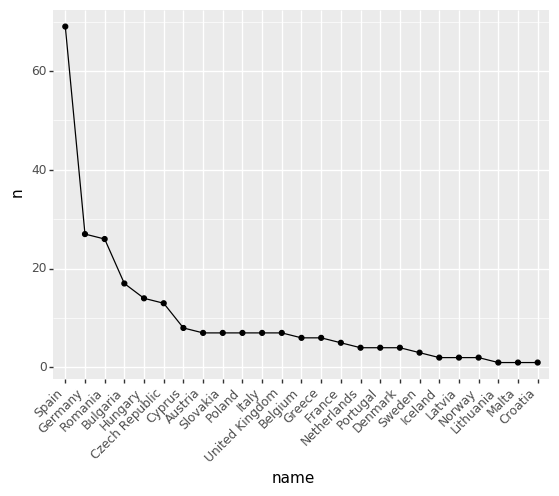

<ggplot: (-9223372036557025234)>

In [2]:
(
    gdpr_violations >> count(_.name, sort = True)
    >> mutate(name = fct_reorder(_.name, -_.n))
    >> ggplot(aes("name", "n", group = 1)) + geom_point() + geom_line()
    + theme(axis_text_x = element_text(angle = 45, hjust = 1))
)

In [3]:
gdpr_violations >> count(_.name, _.controller, sort = True)

gdpr_violations >> filter(_.controller.str.contains("[Gg]oogle"))

,id,picture,name,price,authority,date,controller,article_violated,type,source,summary
65,66,https://www.privacyaffairs.com/wp-content/uplo...,France,50000000,French Data Protection Authority (CNIL),2019-01-21,Google Inc.,Art. 13 GDPR|Art. 14 GDPR|Art. 6 GDPR|Art. 4 G...,Several,https://www.cnil.fr/en/cnils-restricted-commit...,The French NGO “La Quadrature du Net” and the ...
236,237,https://www.privacyaffairs.com/wp-content/uplo...,Sweden,7000000,Data Protection Authority of Sweden,2020-03-11,Google,Art. 5 GDPR|Art. 6 GDPR|Art. 17 GDPR,Failure to comply with data processing principles,https://www.datainspektionen.se/globalassets/d...,"Google was fined with €7,000,000 by the Swedis..."


## GDPR cases over time

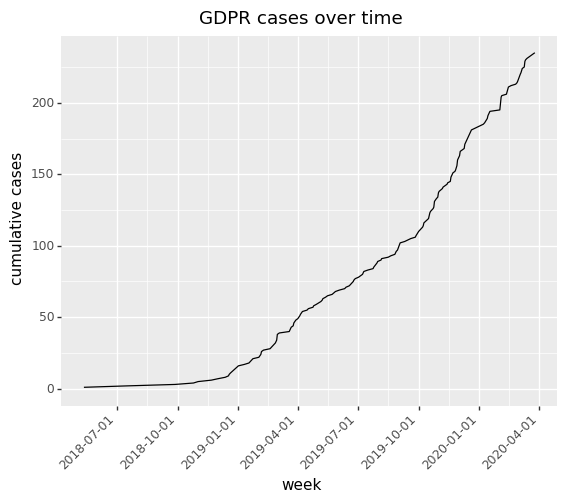

<ggplot: (275505188)>

In [4]:
(
    gdpr_violations
    >> mutate(week = floor_date(_.date, "W"))
    >> filter(_.week != "1970-01-01")
    >> count(_.week)
    >> mutate(ttl = _.n.cumsum())
    >> ggplot(aes("week", "ttl", group = 1)) + geom_line()
    + expand_limits(y = 0)
    + theme(axis_text_x = element_text(angle = 45, hjust = 1))
    + labs(title = "GDPR cases over time", y = "cumulative cases")
#    + scale_y_log10()
)

## Size of fines

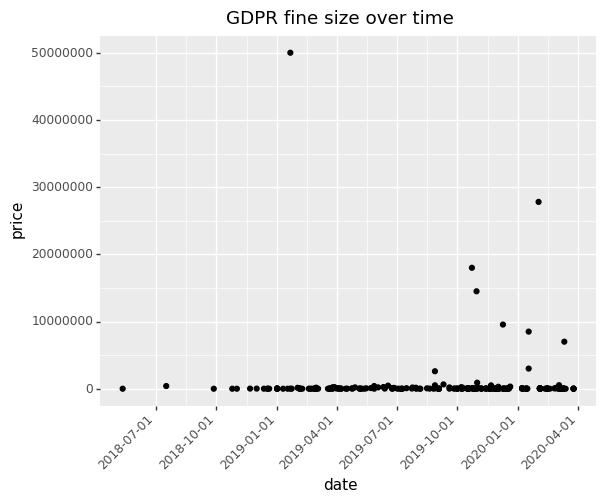

<ggplot: (-9223372036579265613)>

In [5]:
from siuba import arrange

(
    gdpr_violations
    >> filter(_.date != "1970-01-01")
    >> ggplot(aes("date", "price"))
    + geom_point()
    + theme(axis_text_x=element_text(angle=45, hjust=1))
    + labs(title = "GDPR fine size over time")
)

## Type x Price

In [6]:
# multiple articles violated
# * what is type?
# connecting article to other data

#gdpr_violations

In [7]:
type_counts = gdpr_violations >> count(_.type, sort = True)

/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


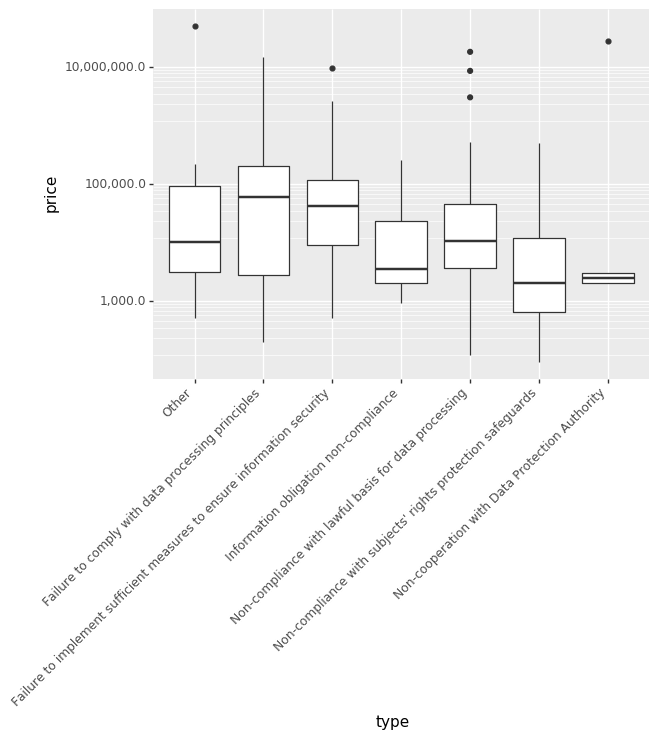

<ggplot: (-9223372036579270449)>

In [8]:
from siuba.dply.forcats import fct_lump

(
    gdpr_violations
    >> add_count(_.type)
    >> mutate(type = fct_lump(_.type, n = 6))
    >> ggplot(aes("type", "price", group="type"))
    + geom_boxplot()
    + scale_y_log10(labels = lambda arr: ["{:,}".format(x) for x in arr])
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)

## Article violated x price

In [9]:
from siuba import unnest, rename

gdpr_articles_nested = gdpr_violations >> mutate(
    articles=_.article_violated.str.split("|"),
    n_violated=_.articles.apply(len)
)

# example ---
# unnest(example.loc[[1], :], "articles")
gdpr_articles = (
    gdpr_articles_nested
    >> unnest("articles")
    >> mutate(article_number = _.articles.str.extract(r"Art. *([0-9]+)").astype(float))
)

/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_ydensity : Removed 11 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


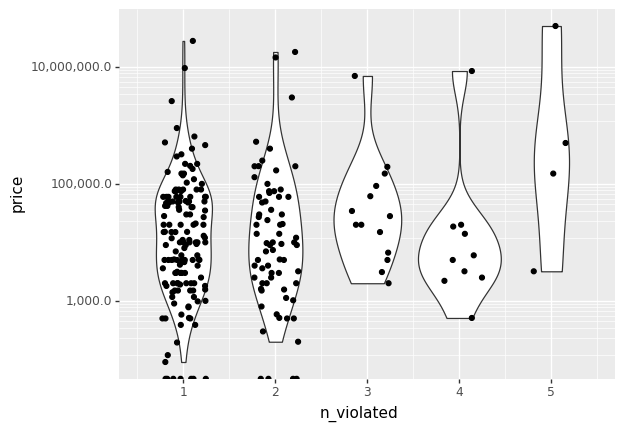

<ggplot: (297460330)>

In [10]:
(
    gdpr_articles_nested
    >> ggplot(aes("n_violated", "price", group="n_violated"))
    + geom_violin()
    + scale_y_log10(labels=lambda arr: ["{:,}".format(x) for x in arr])
    + geom_point(position = position_jitter(height = 0, width = .25))
)

In [11]:
gdpr_articles >> count(_.article_number, sort = True) >> head()

,article_number,n
0,5.0,114
1,6.0,94
2,32.0,61
3,13.0,19
4,15.0,17


In [14]:
from siuba import inner_join, distinct

joined_articles = (
    gdpr_text
    >> distinct(_.article, _.article_title)
    >> inner_join(_, gdpr_articles, {"article": "article_number"})
)

In [ ]:
# sanity check that number of rows is close to gdpr_articles
#joined_articles

/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/machow/.virtualenvs/tidytuesday-py/lib/python3.6/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 13 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


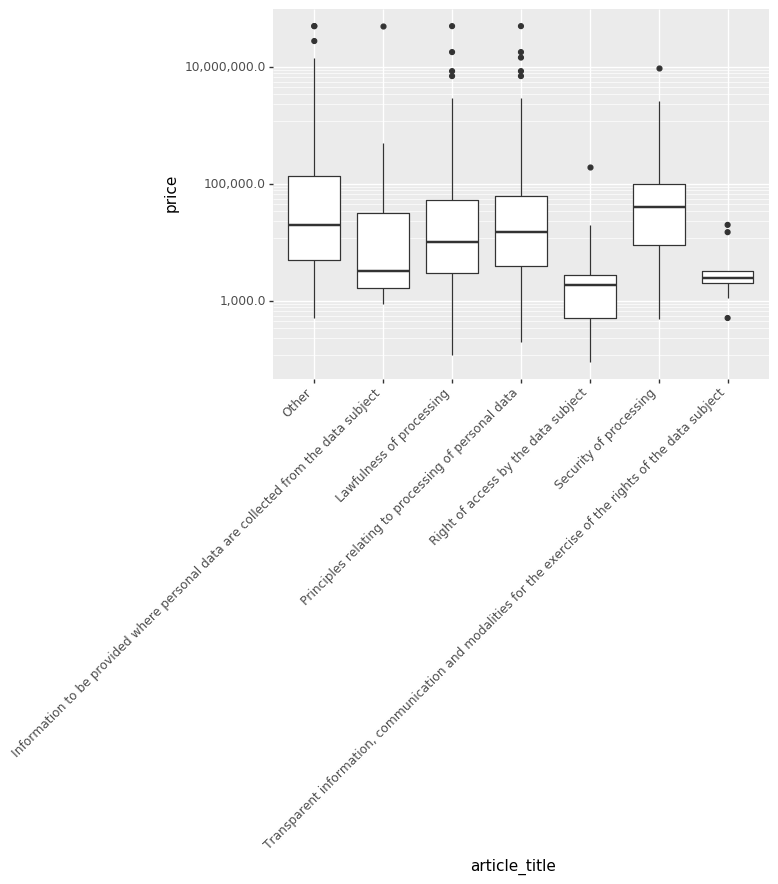

<ggplot: (-9223372036557056978)>

In [15]:
(
    joined_articles
    >> mutate(article_title=fct_lump(_.article_title, n=6))
    >> ggplot(aes("article_title", "price", "article_title")) + geom_boxplot()
        + scale_y_log10(labels = lambda arr: ["{:,}".format(x) for x in arr])
    + theme(axis_text_x=element_text(angle=45, hjust=1))
)